In [232]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat

# Data Import and Cleaning

In [233]:
df = pd.read_excel("/Users/surajkwork/Documents/Thesis/thesis/df.xlsx")
df.head()

,week,wPreis,Plz,full,date
0,2020-37,-37.519318,"['25', '24']",A2 - geschreddert,2020-09-14
1,2020-39,-40.000000,"['25', '24']",A2 - geschreddert,2020-09-28
2,2020-41,-34.853543,"['25', '24']",A2 - geschreddert,2020-10-12
3,2020-42,-27.560202,"['25', '24']",A2 - geschreddert,2020-10-19
4,2020-43,-31.937780,"['25', '24']",A2 - geschreddert,2020-10-26


The date variable is not in datetime format so it has to be converted.

In [234]:
df['date']= pd.to_datetime(df['date'])
df.index = df['date']
df.sort_index(inplace=True)
df.head()

,week,wPreis,Plz,full,date
date,,,,,
2020-09-14,2020-37,-37.519318,"['25', '24']",A2 - geschreddert,2020-09-14
2020-09-14,2020-37,-32.769722,"['50', '51', '52', '53']",A3 - geschreddert,2020-09-14
2020-09-14,2020-37,-33.575183,"['20', '21', '22', '23']",A1 & A2 - geschreddert,2020-09-14
2020-09-14,2020-37,-45.783077,"['40', '41', '42', '44', '45', '46', '47']",A2 & A3 - geschreddert,2020-09-14
2020-09-14,2020-37,-37.519318,"['25', '24']",A1 & A2 - geschreddert,2020-09-14


In [235]:
# pd.DataFrame(df.isnull().sum())

In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3379 entries, 2020-09-14 to 2023-09-04
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   week    3379 non-null   object        
 1   wPreis  3379 non-null   float64       
 2   Plz     3379 non-null   object        
 3   full    3379 non-null   object        
 4   date    3379 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 158.4+ KB


In [237]:
from pandas.api.types import is_numeric_dtype
print(is_numeric_dtype(df['wPreis']))
print(type(df['wPreis']))

True
<class 'pandas.core.series.Series'>


# Data Exploration

There are many clusters in the data set, corresponding to different regions. We will narrow down to one cluster first.

In [238]:
TS1 = df[(df['Plz'] == "['25', '24']")]
TS1.head()

,week,wPreis,Plz,full,date
date,,,,,
2020-09-14,2020-37,-37.519318,"['25', '24']",A2 - geschreddert,2020-09-14
2020-09-14,2020-37,-37.519318,"['25', '24']",A1 & A2 - geschreddert,2020-09-14
2020-09-14,2020-37,-27.983877,"['25', '24']",A2 & A3 - geschreddert,2020-09-14
2020-09-21,2020-38,-27.495024,"['25', '24']",A2 & A3 - geschreddert,2020-09-21
2020-09-28,2020-39,-40.000000,"['25', '24']",A2 - geschreddert,2020-09-28


In [239]:
fig = px.line(TS1, x='date', y='wPreis', color='full', title='Weekly Prices for [25,24] by Category')
fig.show()

 The plot shows that there are upward trends at some periods and downward trends at other periods. This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

In [240]:
unique_values = TS1['full'].unique()
print(unique_values)


['A2 -  geschreddert' 'A1 & A2 -  geschreddert' 'A2 & A3 -  geschreddert']


Even within the cluster, there are multiple categories with different time series. We will focus on one category first. 

In [241]:
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']
TS1_A2.head()

,week,wPreis,Plz,full,date
date,,,,,
2020-09-14,2020-37,-37.519318,"['25', '24']",A2 - geschreddert,2020-09-14
2020-09-28,2020-39,-40.000000,"['25', '24']",A2 - geschreddert,2020-09-28
2020-10-12,2020-41,-34.853543,"['25', '24']",A2 - geschreddert,2020-10-12
2020-10-19,2020-42,-27.560202,"['25', '24']",A2 - geschreddert,2020-10-19
2020-10-26,2020-43,-31.937780,"['25', '24']",A2 - geschreddert,2020-10-26


In [242]:
TS1_A2.info

<bound method DataFrame.info of                week     wPreis           Plz                full       date
date                                                                       
2020-09-14  2020-37 -37.519318  ['25', '24']  A2 -  geschreddert 2020-09-14
2020-09-28  2020-39 -40.000000  ['25', '24']  A2 -  geschreddert 2020-09-28
2020-10-12  2020-41 -34.853543  ['25', '24']  A2 -  geschreddert 2020-10-12
2020-10-19  2020-42 -27.560202  ['25', '24']  A2 -  geschreddert 2020-10-19
2020-10-26  2020-43 -31.937780  ['25', '24']  A2 -  geschreddert 2020-10-26
...             ...        ...           ...                 ...        ...
2023-08-07  2023-32   7.832750  ['25', '24']  A2 -  geschreddert 2023-08-07
2023-08-14  2023-33   3.525113  ['25', '24']  A2 -  geschreddert 2023-08-14
2023-08-21  2023-34   2.021427  ['25', '24']  A2 -  geschreddert 2023-08-21
2023-08-28  2023-35   5.373641  ['25', '24']  A2 -  geschreddert 2023-08-28
2023-09-04  2023-36   2.053265  ['25', '24']  A2 -  gesc

In [243]:
TS1_A2.tail()

,week,wPreis,Plz,full,date
date,,,,,
2023-08-07,2023-32,7.832750,"['25', '24']",A2 - geschreddert,2023-08-07
2023-08-14,2023-33,3.525113,"['25', '24']",A2 - geschreddert,2023-08-14
2023-08-21,2023-34,2.021427,"['25', '24']",A2 - geschreddert,2023-08-21
2023-08-28,2023-35,5.373641,"['25', '24']",A2 - geschreddert,2023-08-28
2023-09-04,2023-36,2.053265,"['25', '24']",A2 - geschreddert,2023-09-04


In [244]:
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

# Plotting ACF and PACF

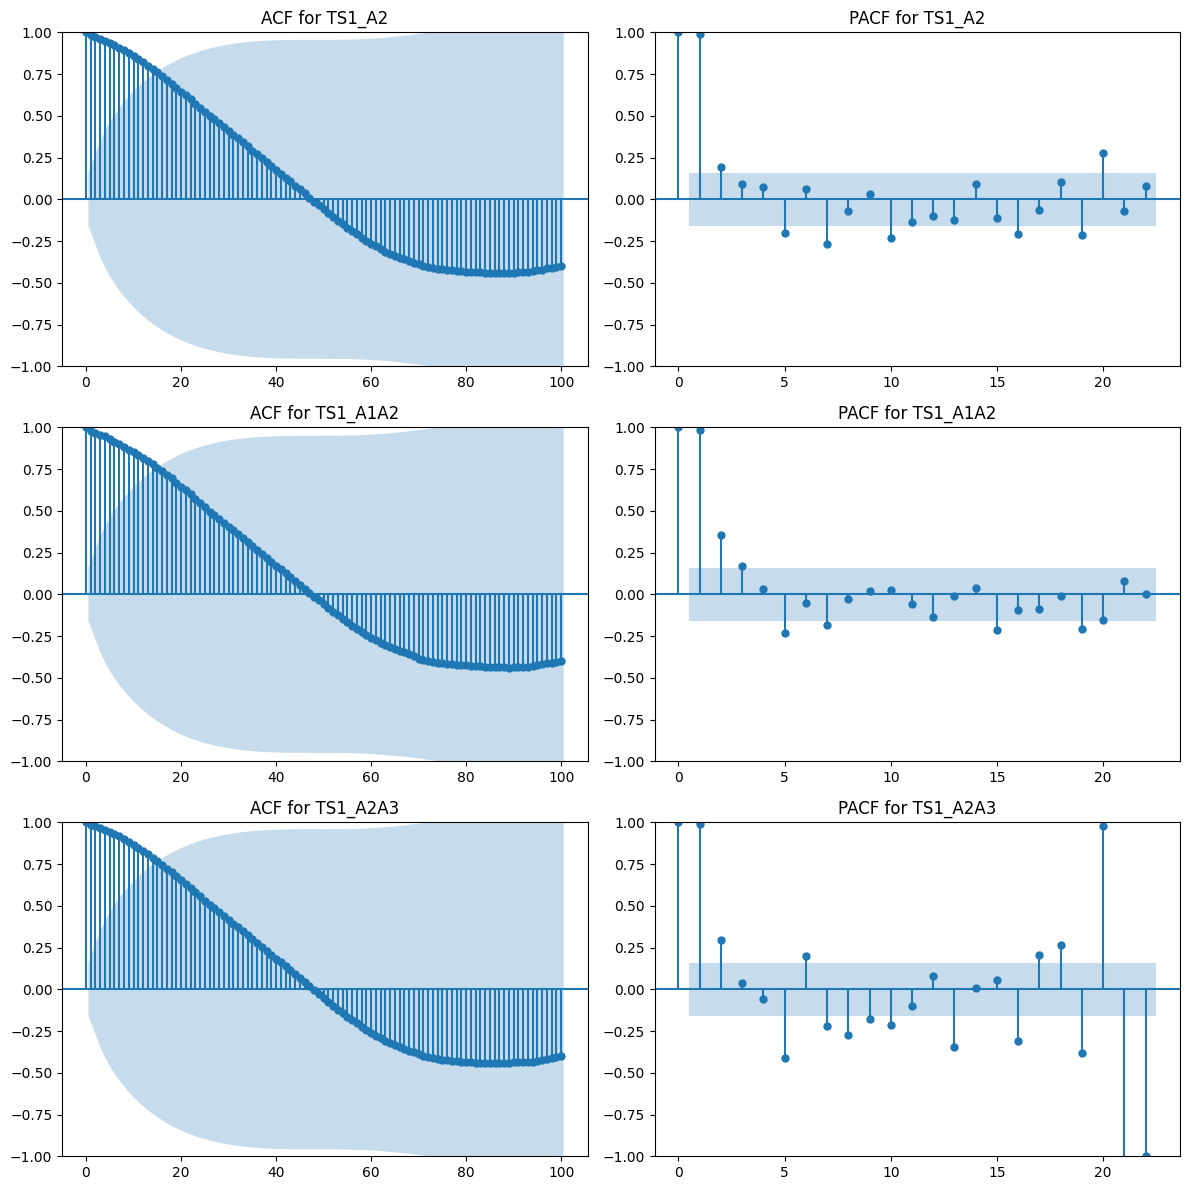

In [245]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# ACF and PACF for TS1_A2
plot_acf(TS1_A2['wPreis'], lags=100, ax=axes[0, 0])
axes[0, 0].set_title('ACF for TS1_A2')
plot_pacf(TS1_A2['wPreis'], ax=axes[0, 1])
axes[0, 1].set_title('PACF for TS1_A2')

# ACF and PACF for TS1_A1A2
plot_acf(TS1_A1A2['wPreis'], lags=100, ax=axes[1, 0])
axes[1, 0].set_title('ACF for TS1_A1A2')
plot_pacf(TS1_A1A2['wPreis'], ax=axes[1, 1])
axes[1, 1].set_title('PACF for TS1_A1A2')

# ACF and PACF for TS1_A2A3
plot_acf(TS1_A2A3['wPreis'], lags=100, ax=axes[2, 0])
axes[2, 0].set_title('ACF for TS1_A2A3')
plot_pacf(TS1_A2A3['wPreis'], ax=axes[2, 1])
axes[2, 1].set_title('PACF for TS1_A2A3')

plt.tight_layout()
plt.show()


- The ACF plots show that there is a positive correlation with the first 10-to-15 lags and it decreases backwards in time until it becomes less significant after around 15 weeks.

- The PACF plots show high correlation for 1 week lag but that is expected. Around 20 weeks, there seems to be a high partial autocorrelation. But we don't read too much into it as this "category" is also a combination of multiple categories.

# Seasonal Decomposition

In [246]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [247]:
def plot_decomposition(TS, freq=4):
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(TS, period=freq)

    # Extract components
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot original time series and components
    plt.figure(figsize=(16, 8))

    plt.subplot(411)
    plt.plot(TS, label="Original")
    plt.title("Decomposition with freq={} weeks".format(freq))
    plt.legend(loc="best")

    plt.subplot(412)
    plt.plot(trend, label="Trend")
    plt.legend(loc="best")

    plt.subplot(413)
    plt.plot(seasonal, label="Seasonality")
    plt.legend(loc="best")

    plt.subplot(414)
    plt.plot(residual, label="Residuals")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

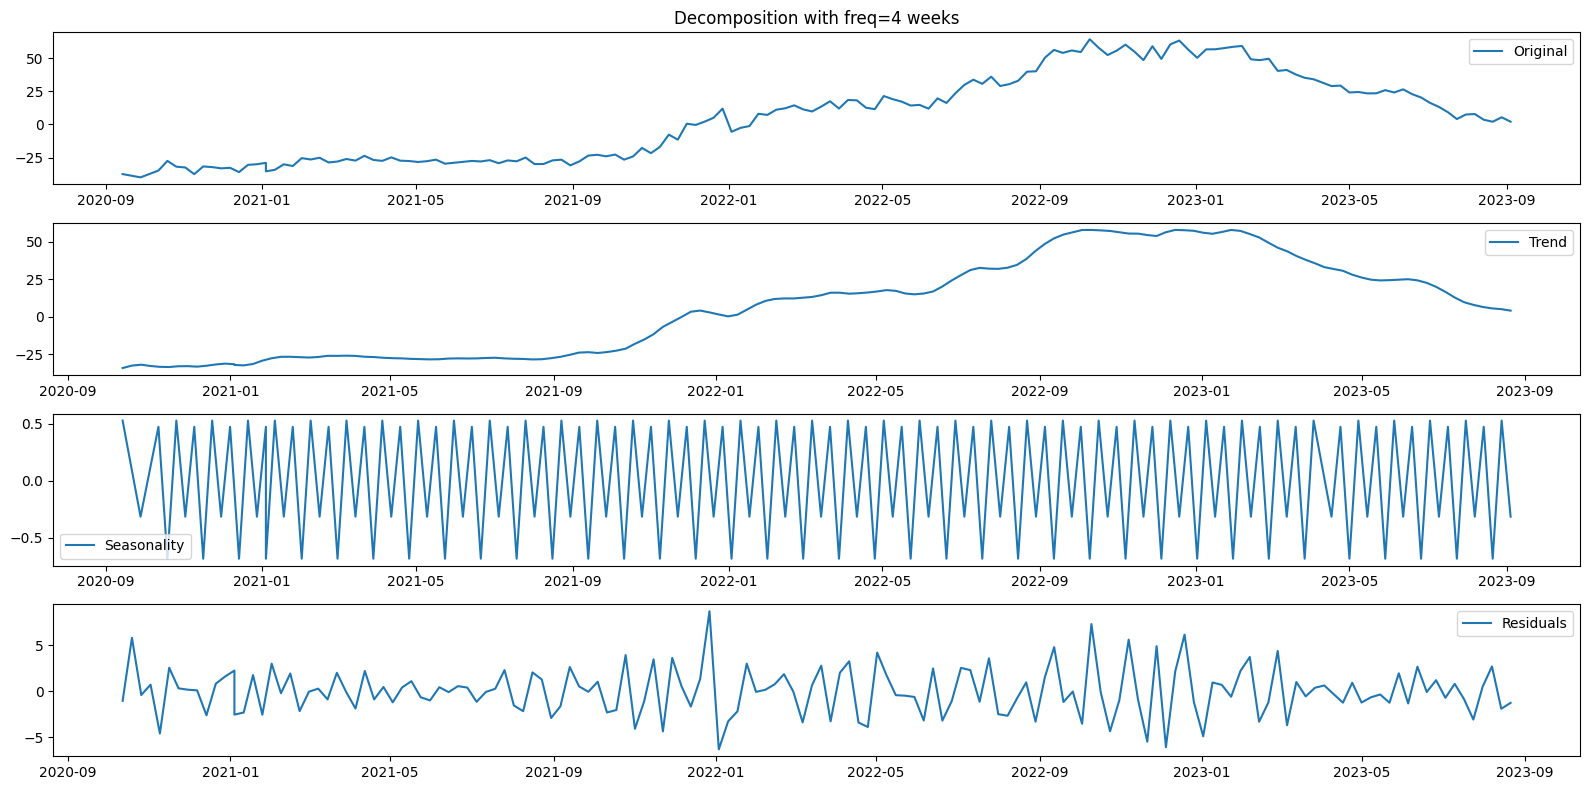

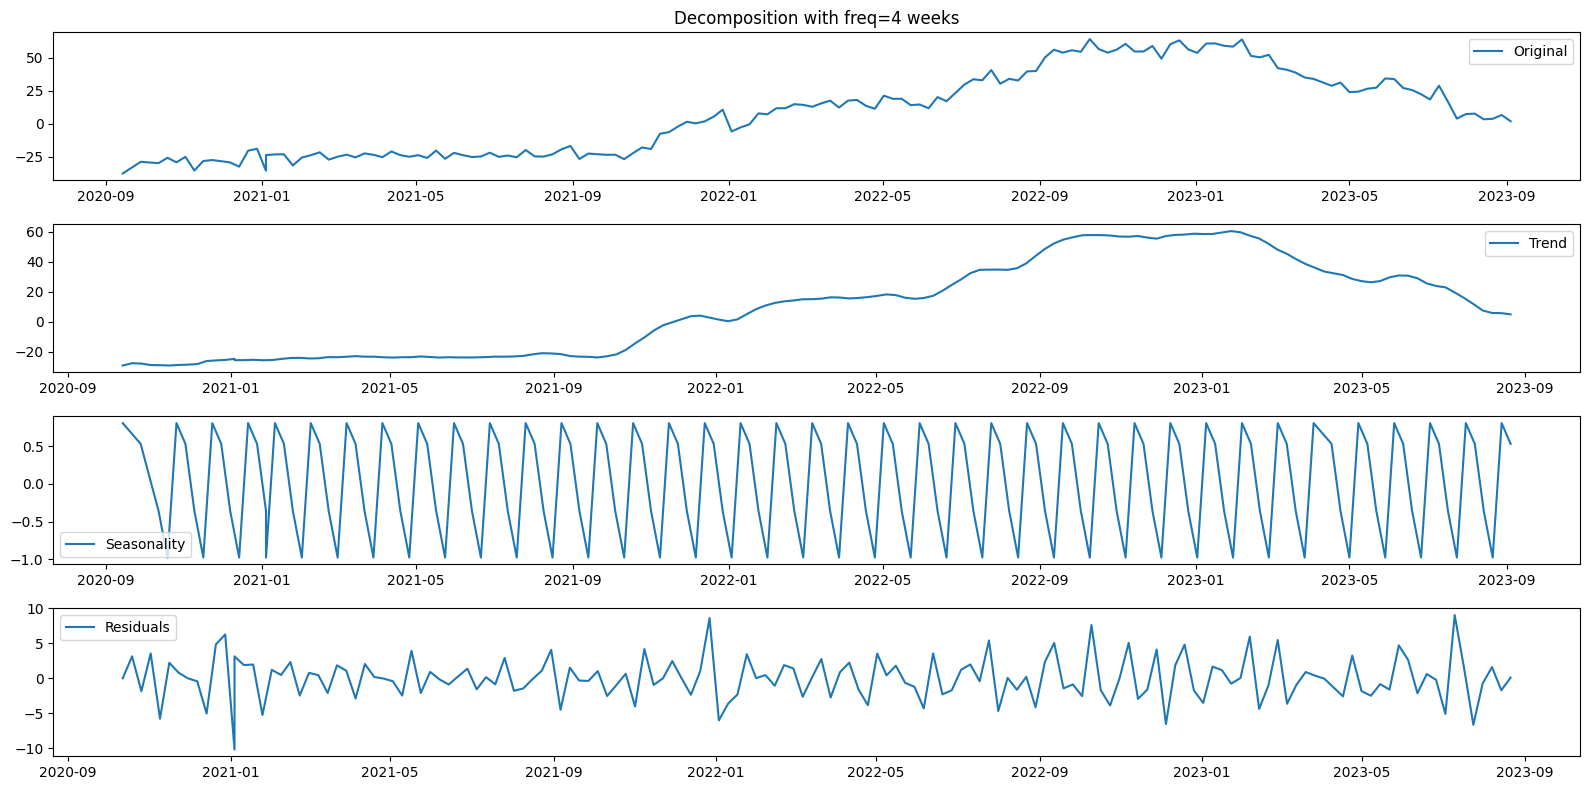

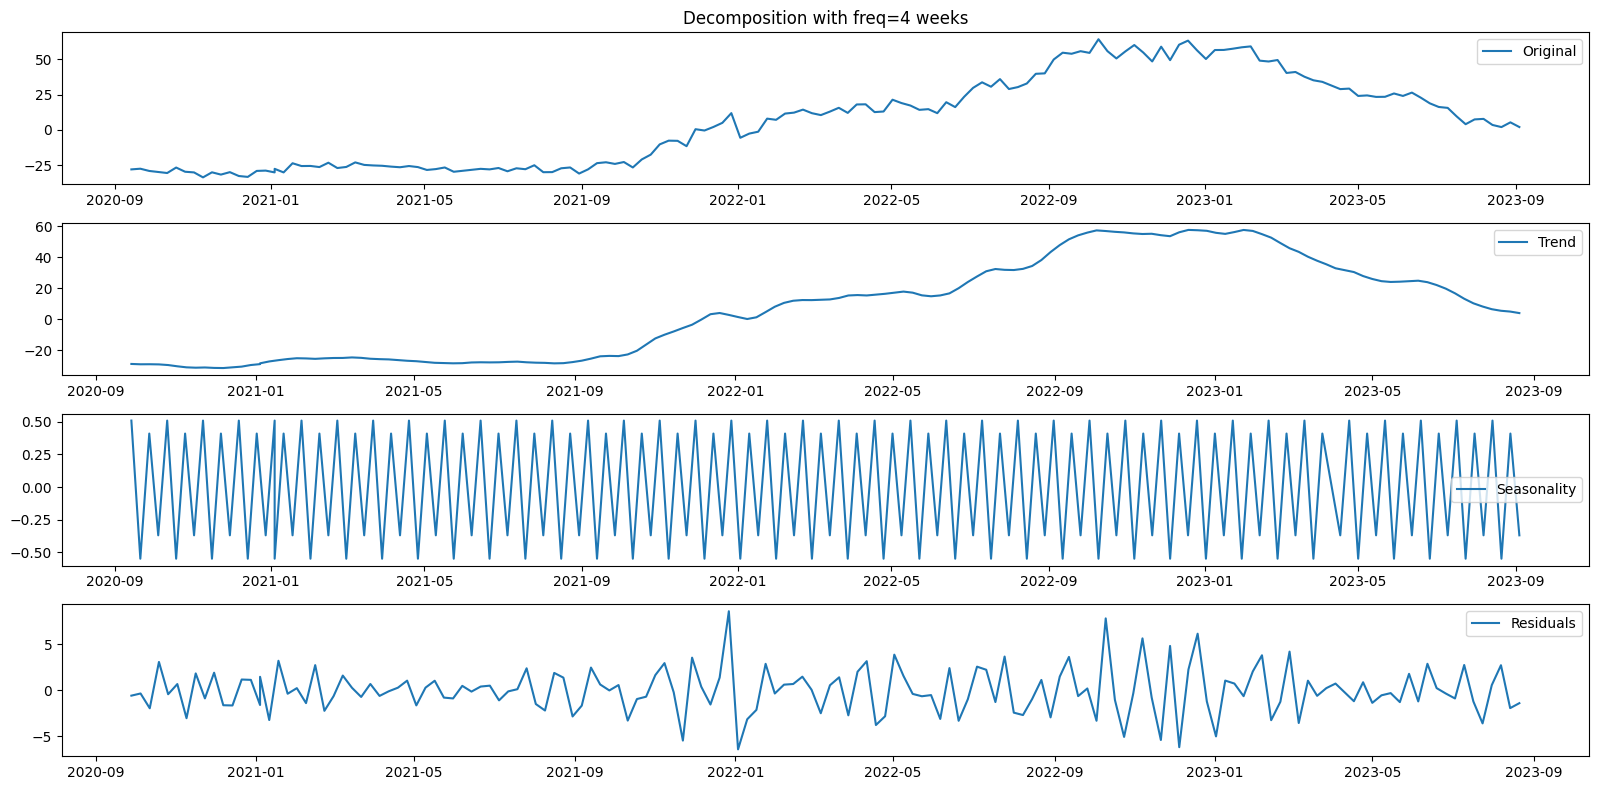

In [248]:
plot_decomposition(TS1_A2["wPreis"].dropna(), freq=4)
plot_decomposition(TS1_A1A2["wPreis"].dropna(), freq=4)
plot_decomposition(TS1_A2A3["wPreis"].dropna(), freq=4)

In [249]:
datasets = [TS1_A2, TS1_A1A2, TS1_A2A3]


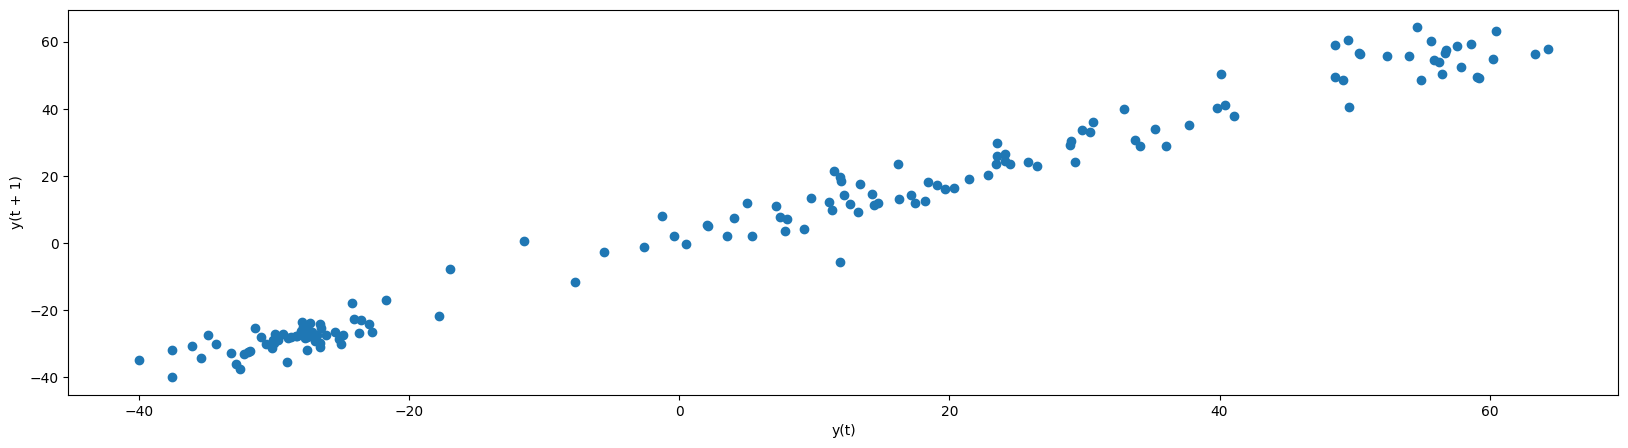

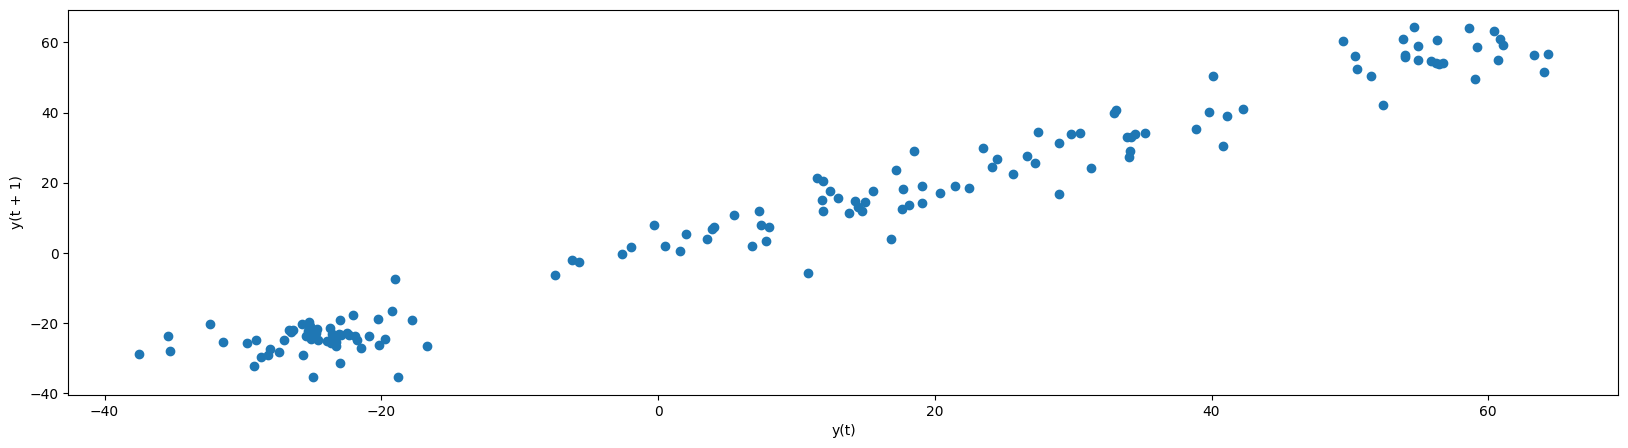

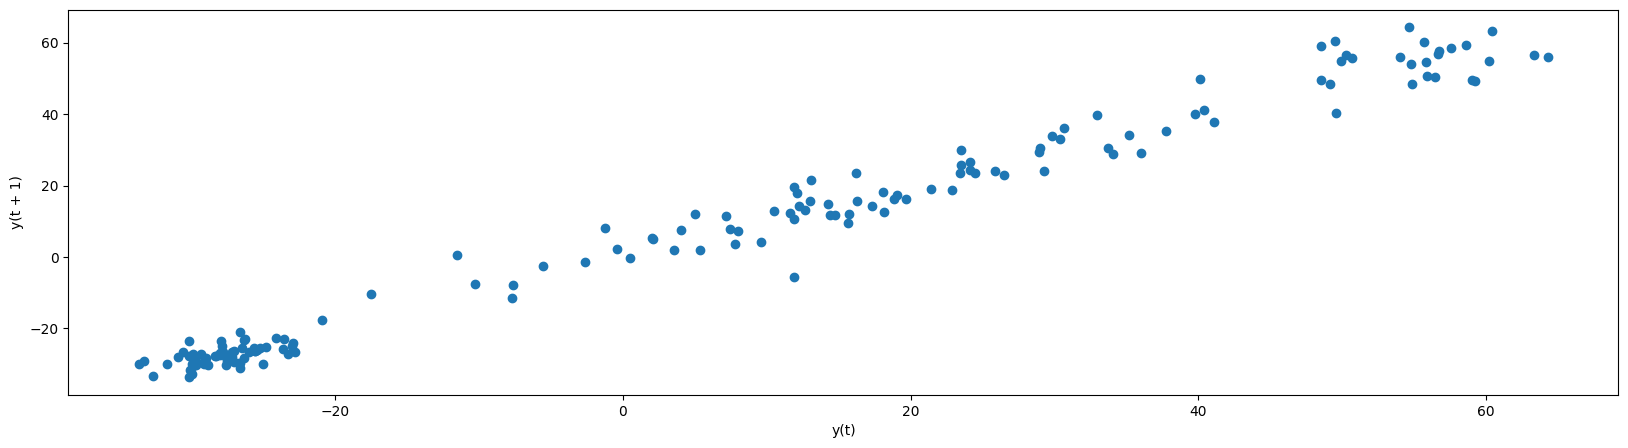

In [250]:
# Lag plot of LQC(coc_mpyn_prfr)
for dataset in datasets:
    plt.figure(figsize=(20,5))
    pd.plotting.lag_plot((dataset['wPreis']), lag= 1)

# Testing for Stationarity

In [251]:
from statsmodels.tsa.stattools import adfuller 

In [252]:
#Perform Dickey-Fuller test:
def test_stationarity(timeseries):    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items(): # key, value mapping
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dftest[0] < dftest[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")

In [253]:
for dataset in datasets:
    test_stationarity(dataset["wPreis"])


Results of Dickey-Fuller Test:
Test Statistic                  -1.211637
p-value                          0.668570
#Lags Used                       4.000000
Number of Observations Used    149.000000
Critical Value (1%)             -3.475018
Critical Value (5%)             -2.881141
Critical Value (10%)            -2.577221
dtype: float64
Failed to Reject Ho - Time Series is Non-Stationary
Results of Dickey-Fuller Test:
Test Statistic                  -1.248179
p-value                          0.652535
#Lags Used                       4.000000
Number of Observations Used    149.000000
Critical Value (1%)             -3.475018
Critical Value (5%)             -2.881141
Critical Value (10%)            -2.577221
dtype: float64
Failed to Reject Ho - Time Series is Non-Stationary
Results of Dickey-Fuller Test:
Test Statistic                  -1.377118
p-value                          0.593195
#Lags Used                       7.000000
Number of Observations Used    148.000000
Critical Value (1

*Since the time series for each of the 3 categories is non-stationary, it means that each of those time series has a relation to time. And that it is worth modelling. *

# Differencing

/var/folders/r5/v547ncv97r9_mbyn2hvcwjz40000gp/T/ipykernel_99095/1635098548.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



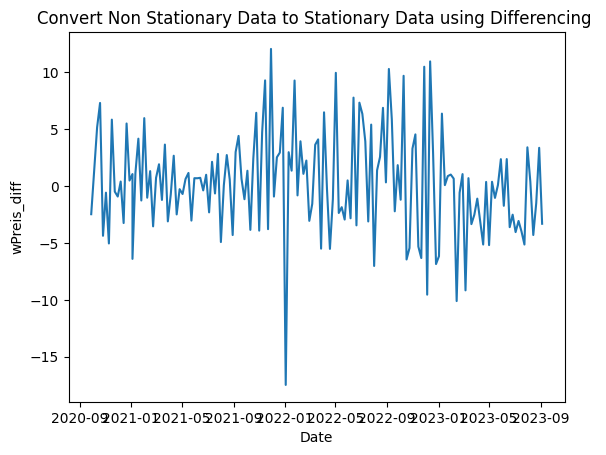

In [254]:
TS1_A2['wPreis_diff'] = TS1_A2['wPreis'].diff()
plt.xlabel('Date')
plt.ylabel('wPreis_diff')    
plt.title('Convert Non Stationary Data to Stationary Data using Differencing ')
plt.plot(TS1_A2['wPreis_diff'])

# df_diff = TS1_A2.diff(periods = 1) # First order differencing
# df_diff
# plt.xlabel('Weeks')
# plt.ylabel('wPreis')    
# plt.title('Convert Non Stationary Data to Stationary Data using Differencing ')
# plt.plot(df_diff)

In [255]:
# Second differencing
TS1_A2['wPreis_diff2'] = TS1_A2['wPreis_diff'].diff()

/var/folders/r5/v547ncv97r9_mbyn2hvcwjz40000gp/T/ipykernel_99095/1661559930.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



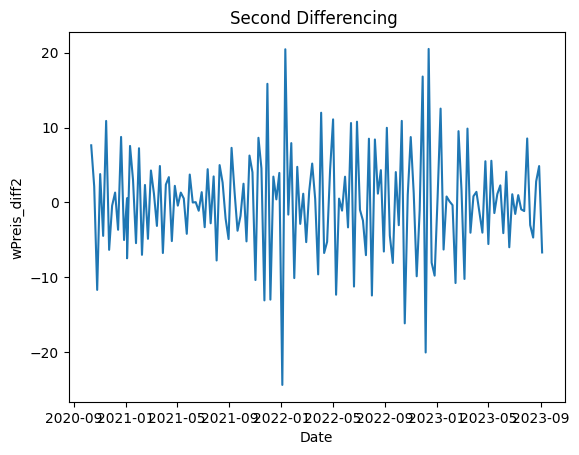

In [256]:
plt.xlabel('Date')
plt.ylabel('wPreis_diff2')    
plt.title('Second Differencing ')
plt.plot(TS1_A2['wPreis_diff2'])

In [257]:
TS1_A2.dropna(inplace = True)
test_stationarity(TS1_A2['wPreis_diff'])


Results of Dickey-Fuller Test:
Test Statistic                  -4.995222
p-value                          0.000023
#Lags Used                       4.000000
Number of Observations Used    147.000000
Critical Value (1%)             -3.475637
Critical Value (5%)             -2.881410
Critical Value (10%)            -2.577365
dtype: float64
Reject Ho - Time Series is Stationary


/var/folders/r5/v547ncv97r9_mbyn2hvcwjz40000gp/T/ipykernel_99095/1823308034.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [258]:
TS1_A2.dropna(inplace = True)
test_stationarity(TS1_A2['wPreis_diff2'])


Results of Dickey-Fuller Test:
Test Statistic                -7.988688e+00
p-value                        2.508359e-12
#Lags Used                     8.000000e+00
Number of Observations Used    1.430000e+02
Critical Value (1%)           -3.476927e+00
Critical Value (5%)           -2.881973e+00
Critical Value (10%)          -2.577665e+00
dtype: float64
Reject Ho - Time Series is Stationary


/var/folders/r5/v547ncv97r9_mbyn2hvcwjz40000gp/T/ipykernel_99095/2296587317.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We have made it stationary. Now we can start modeling.

# Modelling - Train, test split

In [259]:
nobs = 6
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

# Check size
print(df_train.shape) 
print(df_test.shape)  

(148, 5)
(6, 5)


## ARIMA Model



The ARIMA model adds automatic differencing to the ARMA model. It has an additional parameter that can be set to the number of times that the time series needs to be differenced. For example, an ARMA(1,1) that needs to be differenced one time would result in the following notation: ARIMA(1, 1, 1). The first 1 is for the AR order, the second one is for the differencing, and the third 1 is for the MA order. ARIMA(1, 0, 1) would be the same as ARMA(1, 1).

We start with p = 1, d and q = 0 just to check the results.

In [260]:
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA order parameters (p, d, q)
p = 1  # Autoregression order
d = 0  # Differencing order (0 for no differencing)
q = 0  # Moving Average order

# Fit the ARIMA model
model = ARIMA(df_train['wPreis'], order=(p, d, q))
result = model.fit()

# Print model summary
print(result.summary())

# Print AIC, BIC, and other evaluation metrics
print('AIC:', result.aic)
print('BIC:', result.bic)


                               SARIMAX Results                                
Dep. Variable:                 wPreis   No. Observations:                  148
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -461.218
Date:                Fri, 05 Apr 2024   AIC                            928.436
Time:                        13:22:34   BIC                            937.427
Sample:                             0   HQIC                           932.089
                                - 148                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3547     21.077     -0.159      0.874     -44.665      37.956
ar.L1          0.9848      0.013     76.035      0.000       0.959       1.010
sigma2        29.1115      2.996      9.718      0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



There are other tests to check for Residuals.

The main metrics to interpret are:
- AIC: 928.4355146804251. We want this to be as small as possible.

Now we incorporate the first difference by setting d = 1. 
We test different values of p, and with d = 1 (1st order differencing) to see which one yields best results.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so 

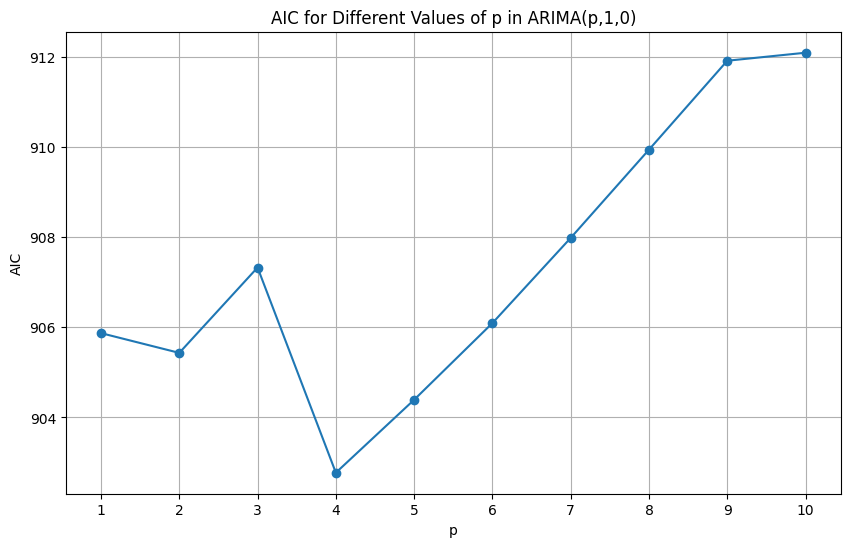

In [261]:
# Define the range of p, d, and q values
p_values = range(1, 5)
d = 1
q = 0

# Define the range of p values
p_values = range(1, 11)

# Initialize lists to store AIC values
aic_values = []

# Iterate over each value of p
for p in p_values:
    # Fit the ARIMA model
    model = ARIMA(df_train['wPreis'], order=(p, d, q))
    result = model.fit()

    # Store the AIC value
    aic_values.append(result.aic)

# Plot the AIC values
plt.figure(figsize=(10, 6))
plt.plot(p_values, aic_values, marker='o', linestyle='-')
plt.xlabel('p')
plt.ylabel('AIC')
plt.title('AIC for Different Values of p in ARIMA(p,1,0)')
plt.grid(True)
plt.xticks(p_values)
plt.show()

The best one has p = 4, d = 1.

In [262]:
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA order parameters (p, d, q)
p = 4  # Autoregression order
d = 1  # Differencing order (0 for no differencing)
q = 0  # Moving Average order

# Fit the ARIMA model
best_model = ARIMA(df_train['wPreis'], order=(p, d, q))
best_model_result = best_model.fit()

# Print model summary
print(result.summary())

# Print AIC, BIC, and other evaluation metrics
print('AIC:', result.aic)
print('BIC:', result.bic)


                               SARIMAX Results                                
Dep. Variable:                 wPreis   No. Observations:                  148
Model:                ARIMA(10, 1, 0)   Log Likelihood                -445.049
Date:                Fri, 05 Apr 2024   AIC                            912.097
Time:                        13:22:36   BIC                            944.992
Sample:                             0   HQIC                           925.463
                                - 148                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3495      0.083     -4.229      0.000      -0.512      -0.188
ar.L2         -0.1233      0.097     -1.272      0.203      -0.313       0.067
ar.L3          0.1103      0.093      1.182      0.2

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



As expected, the AIC for the best one is smaller: 912.0974946293097.
Also plotting the residuals and density to check for bias:

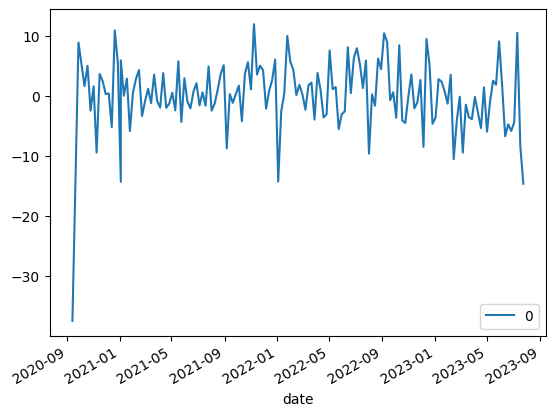

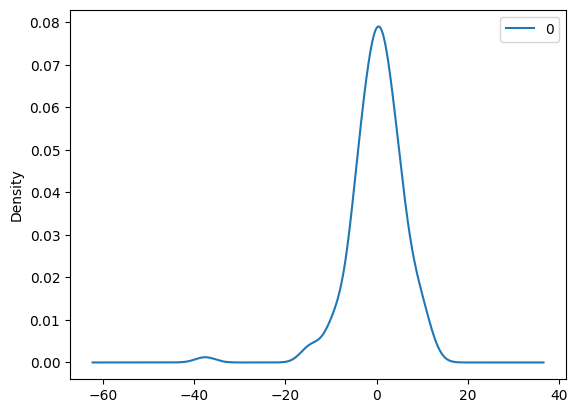

                0
count  148.000000
mean     0.071828
std      5.917809
min    -37.519318
25%     -2.526842
50%      0.442463
75%      3.547620
max     11.886662


In [263]:
from pandas import DataFrame
from matplotlib import pyplot

residuals = DataFrame(best_model_result.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

Since the residual errors don't show a trend, and the mean of the Gaussian is close to zero, we can assume there is no bias.

# Static forecast using ARIMA


No retraining. We just use the best ARIMA model to forecast for the test set and evaluate.
We use the once-trained best ARIMA model to forecast for the 6 "steps" in one go. 

In [264]:
forecast_input = df_train.values[-4:]
fc = best_model_result.forecast(y=forecast_input, steps=nobs) 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [265]:
fc

148     9.790221
149    10.235383
150     5.506046
151     4.813487
152     6.839276
153     5.841581
Name: predicted_mean, dtype: float64

In [266]:
a = np.array(fc)
a

array([ 9.79022128, 10.23538308,  5.50604582,  4.81348739,  6.83927641,
        5.84158137])

In [267]:
test= pd.DataFrame(a, columns=['E'])
test

,E
0,9.790221
1,10.235383
2,5.506046
3,4.813487
4,6.839276
5,5.841581


In [268]:
df_forecast = pd.DataFrame(a, index=df_test.index[-nobs:], columns=['Predicted_wPreis'])
df_forecast

,Predicted_wPreis
date,
2023-07-31,9.790221
2023-08-07,10.235383
2023-08-14,5.506046
2023-08-21,4.813487
2023-08-28,6.839276
2023-09-04,5.841581


In [269]:
df_test

,week,wPreis,Plz,full,date
date,,,,,
2023-07-31,2023-31,7.458214,"['25', '24']",A1 & A2 - geschreddert,2023-07-31
2023-08-07,2023-32,7.832750,"['25', '24']",A1 & A2 - geschreddert,2023-08-07
2023-08-14,2023-33,3.525113,"['25', '24']",A1 & A2 - geschreddert,2023-08-14
2023-08-21,2023-34,3.896402,"['25', '24']",A1 & A2 - geschreddert,2023-08-21
2023-08-28,2023-35,6.754483,"['25', '24']",A1 & A2 - geschreddert,2023-08-28
2023-09-04,2023-36,2.053265,"['25', '24']",A1 & A2 - geschreddert,2023-09-04


In [270]:
df_train.tail()

,week,wPreis,Plz,full,date
date,,,,,
2023-06-26,2023-26,22.501691,"['25', '24']",A1 & A2 - geschreddert,2023-06-26
2023-07-03,2023-27,18.514178,"['25', '24']",A1 & A2 - geschreddert,2023-07-03
2023-07-10,2023-28,28.985554,"['25', '24']",A1 & A2 - geschreddert,2023-07-10
2023-07-17,2023-29,16.847234,"['25', '24']",A1 & A2 - geschreddert,2023-07-17
2023-07-24,2023-30,4.063304,"['25', '24']",A1 & A2 - geschreddert,2023-07-24


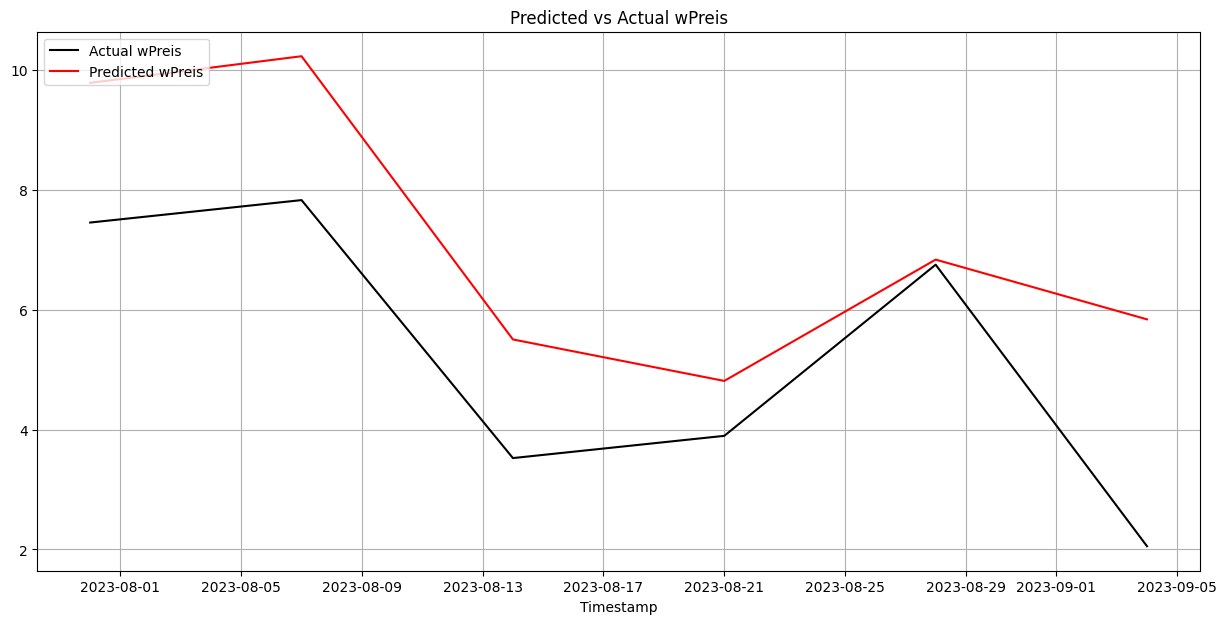

In [271]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 7))
plt.plot(df_test["wPreis"], color='black', label='Actual wPreis')
plt.plot(df_forecast, color='red', label='Predicted wPreis')
plt.xlabel("Timestamp")
plt.grid(True)
plt.legend(loc='upper left')
plt.title('Predicted vs Actual wPreis')
plt.show()

In [272]:
def forecast_accuracy(forecast, actual):
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [273]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Forecast Accuracy of: wPreis')
accuracy_prod = forecast_accuracy(df_forecast['Predicted_wPreis'].values, df_test['wPreis'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: wPreis
me     :  1.9176
rmse   :  2.2485
direction_accuracy :  0.8


# Comparing with forecasts using a rolling window of 4 days


In [274]:
window = df_train['wPreis'][-4:].tolist() 


In [275]:
df_train.shape

(148, 5)

In [276]:
df_train[147:]

,week,wPreis,Plz,full,date
date,,,,,
2023-07-24,2023-30,4.063304,"['25', '24']",A1 & A2 - geschreddert,2023-07-24


In [277]:
test = df_test['wPreis'].tolist()
test

[7.458213826525567,
 7.83274998784697,
 3.525113215314945,
 3.896402411881346,
 6.754482645171904,
 2.053264604810996]

In [278]:
best_model_result.forecast()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



148    9.790221
dtype: float64

Using forecast without arguments only outputs one step.


The statsmodel ARIMAResults object also provides a predict() function for making forecasts.

The predict function can be used to predict arbitrary in-sample and out-of-sample time steps, including the next out-of-sample forecast time step.

The predict function requires a start and an end to be specified, these can be the indexes of the time steps relative to the beginning of the training data used to fit the model, for example:

In [279]:
best_model_result.predict()

date
2020-09-14     0.000000
2020-09-28   -37.518991
2020-10-12   -31.270935
2020-10-19   -30.598988
2020-10-26   -26.570787
                ...    
2023-06-26    28.385991
2023-07-03    22.929523
2023-07-10    18.522545
2023-07-17    25.200498
2023-07-24    18.746575
Name: predicted_mean, Length: 148, dtype: float64

Using predict without output predicts for the index of the entire training dataset, which is not what we want. 

In [280]:
# one-step out of sample forecast
start_index = len(df_train)
end_index = len(df_train)
best_model_result.predict(start=start_index, end=end_index)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



148    9.790221
dtype: float64

In [281]:
start_index+1

149

In [282]:
end_index+1

149

In [283]:
best_model_result.predict(start=start_index+1, end=end_index+1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



149    10.235383
dtype: float64

So updating the index by 1 each time produces different predictions for the next step. This is what we will use in the loop.

In [284]:
df_train.head()

,week,wPreis,Plz,full,date
date,,,,,
2020-09-14,2020-37,-37.519318,"['25', '24']",A1 & A2 - geschreddert,2020-09-14
2020-09-28,2020-39,-28.690096,"['25', '24']",A1 & A2 - geschreddert,2020-09-28
2020-10-12,2020-41,-29.688079,"['25', '24']",A1 & A2 - geschreddert,2020-10-12
2020-10-19,2020-42,-25.630433,"['25', '24']",A1 & A2 - geschreddert,2020-10-19
2020-10-26,2020-43,-29.073794,"['25', '24']",A1 & A2 - geschreddert,2020-10-26


In [285]:
df_train.tail()

,week,wPreis,Plz,full,date
date,,,,,
2023-06-26,2023-26,22.501691,"['25', '24']",A1 & A2 - geschreddert,2023-06-26
2023-07-03,2023-27,18.514178,"['25', '24']",A1 & A2 - geschreddert,2023-07-03
2023-07-10,2023-28,28.985554,"['25', '24']",A1 & A2 - geschreddert,2023-07-10
2023-07-17,2023-29,16.847234,"['25', '24']",A1 & A2 - geschreddert,2023-07-17
2023-07-24,2023-30,4.063304,"['25', '24']",A1 & A2 - geschreddert,2023-07-24


In [286]:
df_test

,week,wPreis,Plz,full,date
date,,,,,
2023-07-31,2023-31,7.458214,"['25', '24']",A1 & A2 - geschreddert,2023-07-31
2023-08-07,2023-32,7.832750,"['25', '24']",A1 & A2 - geschreddert,2023-08-07
2023-08-14,2023-33,3.525113,"['25', '24']",A1 & A2 - geschreddert,2023-08-14
2023-08-21,2023-34,3.896402,"['25', '24']",A1 & A2 - geschreddert,2023-08-21
2023-08-28,2023-35,6.754483,"['25', '24']",A1 & A2 - geschreddert,2023-08-28
2023-09-04,2023-36,2.053265,"['25', '24']",A1 & A2 - geschreddert,2023-09-04


In [287]:
best_model_result.predict(steps=6)

date
2020-09-14     0.000000
2020-09-28   -37.518991
2020-10-12   -31.270935
2020-10-19   -30.598988
2020-10-26   -26.570787
                ...    
2023-06-26    28.385991
2023-07-03    22.929523
2023-07-10    18.522545
2023-07-17    25.200498
2023-07-24    18.746575
Name: predicted_mean, Length: 148, dtype: float64

In [288]:
rolling_predictions = list()
rolling_expect=[]

# Iterate over each step in the test set
for t in range(len(test)):
    output = best_model_result.predict(start=start_index+t, end=end_index+t)  # Going through each of the t and predicting for that tth step. 
    obs = test[t]
    # window.pop(0)  # Remove the oldest value
    # window.append(obs)  # Add the actual value from the test set
    rolling_predictions.append(output)
    print(rolling_predictions)


[148    9.790221
dtype: float64]
[148    9.790221
dtype: float64, 149    10.235383
dtype: float64]
[148    9.790221
dtype: float64, 149    10.235383
dtype: float64, 150    5.506046
dtype: float64]
[148    9.790221
dtype: float64, 149    10.235383
dtype: float64, 150    5.506046
dtype: float64, 151    4.813487
dtype: float64]
[148    9.790221
dtype: float64, 149    10.235383
dtype: float64, 150    5.506046
dtype: float64, 151    4.813487
dtype: float64, 152    6.839276
dtype: float64]
[148    9.790221
dtype: float64, 149    10.235383
dtype: float64, 150    5.506046
dtype: float64, 151    4.813487
dtype: float64, 152    6.839276
dtype: float64, 153    5.841581
dtype: float64]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Library/Frameworks/

In [289]:
rolling_predictions

[148    9.790221
 dtype: float64,
 149    10.235383
 dtype: float64,
 150    5.506046
 dtype: float64,
 151    4.813487
 dtype: float64,
 152    6.839276
 dtype: float64,
 153    5.841581
 dtype: float64]

 Now we get different values for the predictions.

In [290]:
rolling_forecast = pd.DataFrame(rolling_predictions, index=df_test.index[-nobs:], columns=['Predicted_Rolling_wPreis'])



In [291]:
print(len(df_test.index[-nobs:]), len(rolling_predictions))


6 6


In [292]:
# Extract values from rolling_predictions
rolling_values = [x.iloc[0] if isinstance(x, pd.Series) else x for x in rolling_predictions]

# Create DataFrame
rolling_forecast = pd.DataFrame({'Predicted_Rolling_wPreis': rolling_values}, index=df_test.index[-nobs:])


In [293]:
rolling_forecast

,Predicted_Rolling_wPreis
date,
2023-07-31,9.790221
2023-08-07,10.235383
2023-08-14,5.506046
2023-08-21,4.813487
2023-08-28,6.839276
2023-09-04,5.841581


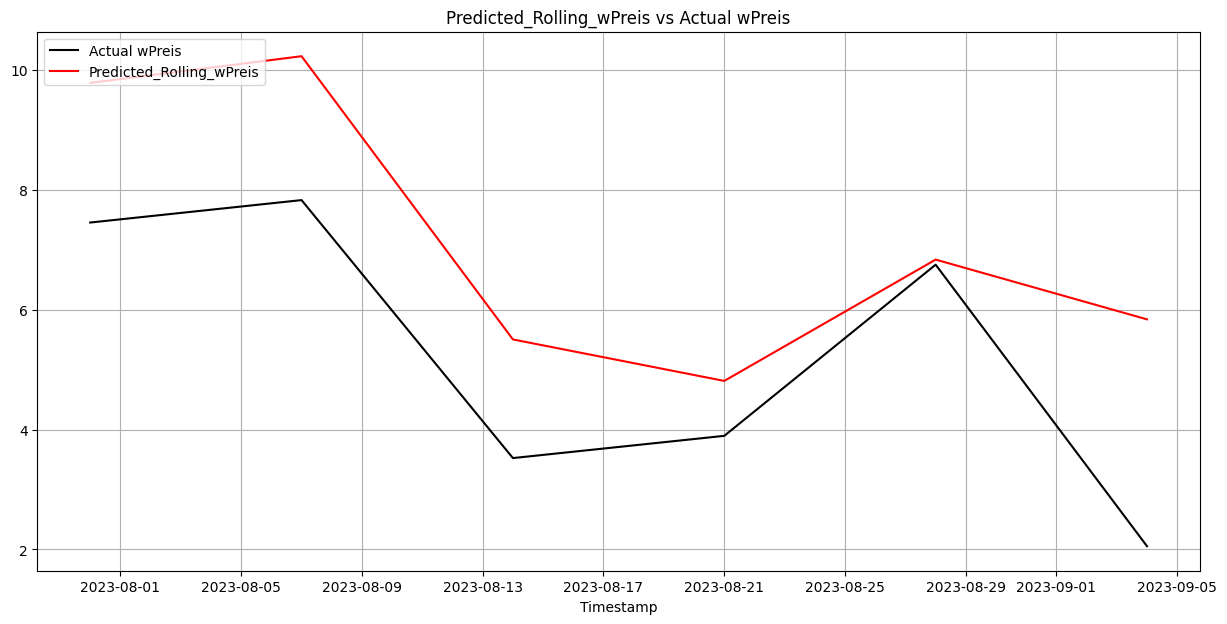

In [294]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 7))
plt.plot(df_test["wPreis"], color='black', label='Actual wPreis')
plt.plot(rolling_forecast, color='red', label='Predicted_Rolling_wPreis')
plt.xlabel("Timestamp")
plt.grid(True)
plt.legend(loc='upper left')
plt.title('Predicted_Rolling_wPreis vs Actual wPreis')
plt.show()

In [295]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Forecast Accuracy of: Predicted_Rolling_wPreis')

accuracy_rolling = forecast_accuracy(rolling_forecast['Predicted_Rolling_wPreis'].values, df_test['wPreis'])
for k, v in accuracy_rolling.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Predicted_Rolling_wPreis
me     :  1.9176
rmse   :  2.2485
direction_accuracy :  0.8


We get the sane results as Static Forecasting. Need to relook at this again.

## Attempt which includes training model at every step, with the new window.

In [296]:
window2 = df_train['wPreis'][-4:].tolist() 

rolling_predictions2 = list()
rolling_expect2=[]

# Iterate over each step in the test set
for t in range(len(test)):
    #print(window2)
    model2 = ARIMA(window2, order=(4,1,0))  # Training on window is not correct. Should be on whole history. Check if ARIMA has sliding windows already.
    model2_fit = model2.fit()
    output2 = model2_fit.forecast()
    yhat2 = output2[0]
    rolling_predictions2.append(yhat2)
    obs2 = test[t]
    window2.pop(0)  # Remove the oldest value
    window2.append(obs2)  # Add the actual value from the test set
    rolling_expect2.append(obs2)

print(rolling_expect2)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[7.458213826525567, 7.83274998784697, 3.525113215314945, 3.896402411881346, 6.754482645171904, 2.053264604810996]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [297]:
print(rolling_predictions2)


[13.763099253732536, 22.563850880479947, 6.146355250559185, 10.223730891737887, -0.41114857517505143, 3.489867432785822]


In [298]:
rolling_forecast2 = pd.DataFrame(rolling_predictions2, index=df_test.index[-nobs:], columns=['Predicted_Rolling_wPreis'])
rolling_forecast2

,Predicted_Rolling_wPreis
date,
2023-07-31,13.763099
2023-08-07,22.563851
2023-08-14,6.146355
2023-08-21,10.223731
2023-08-28,-0.411149
2023-09-04,3.489867


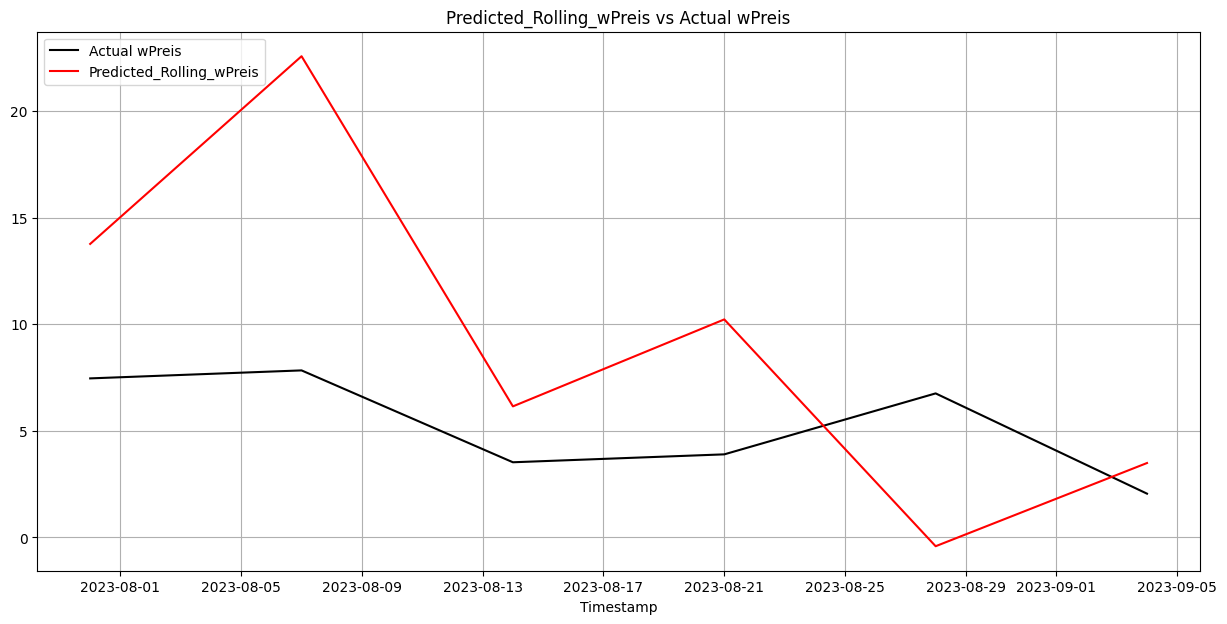

In [299]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 7))
plt.plot(df_test["wPreis"], color='black', label='Actual wPreis')
plt.plot(rolling_forecast2, color='red', label='Predicted_Rolling_wPreis')
plt.xlabel("Timestamp")
plt.grid(True)
plt.legend(loc='upper left')
plt.title('Predicted_Rolling_wPreis vs Actual wPreis')
plt.show()

In [300]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Forecast Accuracy of: Predicted_Rolling_wPreis')

accuracy_rolling = forecast_accuracy(rolling_forecast2['Predicted_Rolling_wPreis'].values, df_test['wPreis'])
for k, v in accuracy_rolling.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Predicted_Rolling_wPreis
me     :  4.0426
rmse   :  7.7144
direction_accuracy :  0.6


Now the metrics are different from static but they have got worse.


# Walk forward validation using ARIMA model

Training the whole model at each iteration including the new observation (for the next day)  

In [301]:
X = TS1_A1A2["wPreis"].values
len(X)


154

In [302]:
TS1_A1A2.tail()

,week,wPreis,Plz,full,date
date,,,,,
2023-08-07,2023-32,7.832750,"['25', '24']",A1 & A2 - geschreddert,2023-08-07
2023-08-14,2023-33,3.525113,"['25', '24']",A1 & A2 - geschreddert,2023-08-14
2023-08-21,2023-34,3.896402,"['25', '24']",A1 & A2 - geschreddert,2023-08-21
2023-08-28,2023-35,6.754483,"['25', '24']",A1 & A2 - geschreddert,2023-08-28
2023-09-04,2023-36,2.053265,"['25', '24']",A1 & A2 - geschreddert,2023-09-04


Take 148 observations for training and 6 for testing.

In [303]:
size = 148
train, test = X[0:size], X[size:len(X)] 

In [304]:
history = [x for x in train] # "list comprehensions". 
expect=[]

In [305]:
predictions = list()
for t in range(len(test)): # 6 times reiterate
    model = ARIMA(history, order=(4,1,0))  
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs) # appends the real observation at each loop! 
    expect.append(obs)

    
print(expect)
print(predictions)

[7.458213826525567, 7.83274998784697, 3.525113215314945, 3.896402411881346, 6.754482645171904, 2.053264604810996]
[9.79022128073552, 8.650013137338217, 3.4034989388875347, 2.4277212680820854, 4.937116018889061, 5.4229451851235035]


In [306]:
df_wPreis = pd.DataFrame(
    {'observations': expect,
     'forecast': predictions, 
    })
df_wPreis

,observations,forecast
0,7.458214,9.790221
1,7.832750,8.650013
2,3.525113,3.403499
3,3.896402,2.427721
4,6.754483,4.937116
5,2.053265,5.422945


Take the inverse transformation to get the wPReis. Not the difference.
Compare the signs - up or down. Just count the number of times they are in the same direction. 

In [307]:
df_wPreis.diff()

,observations,forecast
0,NaN,NaN
1,0.374536,-1.140208
2,-4.307637,-5.246514
3,0.371289,-0.975778
4,2.858080,2.509395
5,-4.701218,0.485829


In [308]:
def adjust(val, length= 10): return str(val).ljust(length) # 10
print('Forecast Accuracy of wPreis')
accuracy_prod = forecast_accuracy(df_wPreis['forecast'].values, df_wPreis['observations'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of wPreis
me         :  0.5185
rmse       :  1.9551
direction_accuracy :  0.4


Here, the me and rmse has improved but the direction_accuracy has decreased even further!

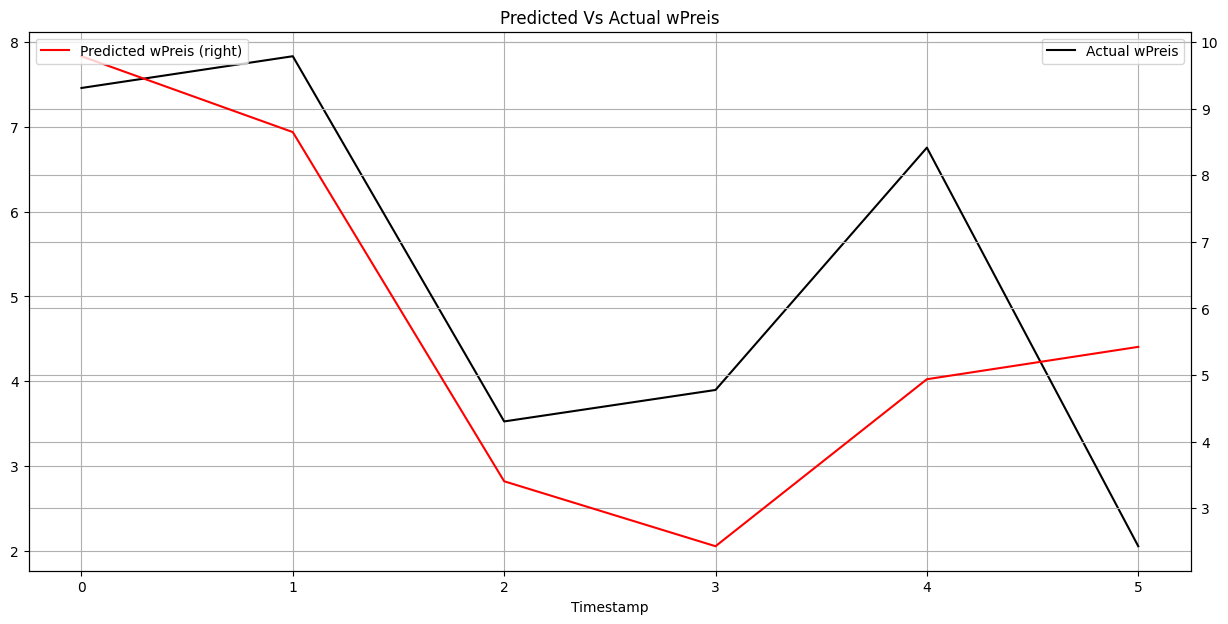

In [309]:
plt.figure(figsize= (15,7))
plt.xlabel("Timestamp")

ax1 = df_wPreis.observations.plot(color = 'black', grid = True, label = 'Actual wPreis')
ax2 = df_wPreis.forecast.plot(color = 'red', grid = True, secondary_y = True, label = 'Predicted wPreis')

ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title('Predicted Vs Actual wPreis')
plt.show()

In [310]:
# evaluate_arima_model(X, (2,0,0))

Evaluating different combinations of p,d,q values to find the one with the best (smallest) RMSE:

In [311]:
# # evaluate combinations of p, d and q values for an ARIMA model
# def evaluate_models(dataset, p_values, d_values, q_values):
#     dataset = dataset.astype('float32')
#     best_score, best_cfg = float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 order = (p,d,q)
#                 try:
#                     rmse = evaluate_arima_model(dataset, order)
#                     if rmse < best_score:
#                         best_score, best_cfg = rmse, order
#                     print('ARIMA%s RMSE=%.3f' % (order,rmse))
#                 except:
#                     continue
#     print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

Evaluating the best ARIMA model for the best combination of parameters p,q and d

In [312]:
# import warnings
# p_values = range(1,5)
# d_values = range(1,3)
# q_values = range(1,3)
# warnings.filterwarnings("ignore")
# evaluate_models(X, p_values, d_values, q_values)

### Best ARIMA(5, 3, 2) RMSE=5.586


# XGBOOST

In [313]:
from xgboost import XGBRegressor


In [314]:
from pandas import concat


In [315]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
# drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values

In [316]:

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
 return data[:-n_test, :], data[-n_test:, :]

In [317]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict(asarray([testX]))
 return yhat[0]

## Walk-forward validation using XGBoost

Retraining model on updated training data, appended at every step to add the new value from test set.

In [318]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
 # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = xgboost_forecast(history, testX)
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)

    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy

1. COMPARE XGBOOST FOR STATIC FORECAST.
2. COMPARE XGBOOST FOR ROLLING WINDOWS (TRAINING WHOLE TRAINING DATASET APART FROM LAST 4 BUT FORECAST WITH INPUT SLIDING WITH APPEND FROM TEST)

In [319]:
import numpy as np


In [320]:
np.random.seed(123)
t = np.arange(100)
y = t + 2 * np.random.normal(size = 100)#linear trend
t_train = t[:50].reshape(-1,1)
t_test = t[50:].reshape(-1,1)
y_train = y[:50]
y_test = y[50:]

In [321]:
t_train

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49]])

In [322]:
t_test

array([[50],
       [51],
       [52],
       [53],
       [54],
       [55],
       [56],
       [57],
       [58],
       [59],
       [60],
       [61],
       [62],
       [63],
       [64],
       [65],
       [66],
       [67],
       [68],
       [69],
       [70],
       [71],
       [72],
       [73],
       [74],
       [75],
       [76],
       [77],
       [78],
       [79],
       [80],
       [81],
       [82],
       [83],
       [84],
       [85],
       [86],
       [87],
       [88],
       [89],
       [90],
       [91],
       [92],
       [93],
       [94],
       [95],
       [96],
       [97],
       [98],
       [99]])

In [323]:
y_train

array([-2.17126121e+00,  2.99469089e+00,  2.56595700e+00, -1.25894278e-02,
        2.84279950e+00,  8.30287307e+00,  1.14664151e+00,  6.14217474e+00,
        1.05318725e+01,  7.26651920e+00,  8.64222770e+00,  1.08105821e+01,
        1.49827793e+01,  1.17221960e+01,  1.31120361e+01,  1.41312974e+01,
        2.04118602e+01,  2.13735722e+01,  2.00081078e+01,  1.97723728e+01,
        2.14747372e+01,  2.39814641e+01,  2.01283323e+01,  2.53516581e+01,
        2.14922387e+01,  2.37244970e+01,  2.78142104e+01,  2.41426386e+01,
        2.77198626e+01,  2.72764902e+01,  2.94887613e+01,  2.54028218e+01,
        2.84569338e+01,  3.16002455e+01,  3.58549249e+01,  3.46527286e+01,
        3.60056918e+01,  3.83764454e+01,  3.62409273e+01,  3.95672546e+01,
        3.83892670e+01,  3.75446610e+01,  4.12182004e+01,  4.41476117e+01,
        4.46771781e+01,  4.49763390e+01,  5.07847305e+01,  4.78258243e+01,
        4.99574720e+01,  5.34762867e+01])

In [324]:
y_test

array([47.41182935, 48.92242358, 55.48742445, 51.40387453, 54.05936646,
       57.13863194, 57.78141278, 60.50977236, 60.99128827, 61.13878534,
       58.45458257, 62.58972534, 62.62854399, 60.34746908, 66.83459809,
       66.61447307, 66.09098016, 66.53381588, 65.60339771, 69.39904815,
       70.93687824, 69.33769003, 74.3244081 , 70.80559391, 69.7537993 ,
       77.07945418, 75.19326792, 76.74794083, 76.32496655, 75.78807448,
       82.51047475, 79.62226203, 85.32190498, 84.61461637, 83.37048371,
       82.8281952 , 84.53507603, 84.57495374, 92.17422672, 89.32888246,
       92.30041109, 88.4652959 , 92.36207026, 95.35572388, 93.32997848,
       97.06222892, 93.83086418, 94.27305691, 98.75880122, 98.24164713])

In [325]:
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)

In [326]:
# transform the time series data into supervised learning
data = series_to_supervised(X, n_in=4)

In [327]:
# evaluate
mae, me, rmse, y, yhat, direction_accuracy = walk_forward_validation(data, 6)
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

>expected=7.5, predicted=15.1
>expected=7.8, predicted=9.0
>expected=3.5, predicted=6.0
>expected=3.9, predicted=6.1
>expected=6.8, predicted=7.1
>expected=2.1, predicted=4.7


NameError: name 'mean_squared_error' is not defined

The metrics are poorer than Static ARIMA but directino accuracy is similar.

## Static forecast with XGBoost

No retraining. We just use the XGBoost model to forecast for the 6 "steps" in test set and evaluate.

UPDATE: THERE MAY NOT BE SUCH A THING AS STATIC FORECASTING FOR XGBOOST. THE PREDICT MODEL TAKES AN INPUT (WHICH IS THE 4-DAY LAG) AND PREDICTS THE NEXT STEP AND TO PREDICT THE 6 DAYS THIS "WINDOW" HAS TO BE MOVED FOR INPUT. SO EITHER THERE IS ROLLING OR WALK-FORWARD VALIDATION FOR XGBOOST.

In [ ]:
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)

In [ ]:
# transform the time series data into supervised learning
data = series_to_supervised(X, n_in=4)

In [ ]:
data

array([[-37.51931788, -28.69009585, -29.68807862, -25.6304334 ,
        -29.07379398],
       [-28.69009585, -29.68807862, -25.6304334 , -29.07379398,
        -24.93642602],
       [-29.68807862, -25.6304334 , -29.07379398, -24.93642602,
        -35.26209517],
       [-25.6304334 , -29.07379398, -24.93642602, -35.26209517,
        -28.06563229],
       [-29.07379398, -24.93642602, -35.26209517, -28.06563229,
        -27.35874871],
       [-24.93642602, -35.26209517, -28.06563229, -27.35874871,
        -28.21685813],
       [-35.26209517, -28.06563229, -27.35874871, -28.21685813,
        -29.18520815],
       [-28.06563229, -27.35874871, -28.21685813, -29.18520815,
        -32.36064526],
       [-27.35874871, -28.21685813, -29.18520815, -32.36064526,
        -20.27214677],
       [-28.21685813, -29.18520815, -32.36064526, -20.27214677,
        -18.80845203],
       [-29.18520815, -32.36064526, -20.27214677, -18.80845203,
        -35.43666563],
       [-32.36064526, -20.27214677, -18.808

In [ ]:
train, test = train_test_split(data, 6)
train

array([[-37.51931788, -28.69009585, -29.68807862, -25.6304334 ,
        -29.07379398],
       [-28.69009585, -29.68807862, -25.6304334 , -29.07379398,
        -24.93642602],
       [-29.68807862, -25.6304334 , -29.07379398, -24.93642602,
        -35.26209517],
       [-25.6304334 , -29.07379398, -24.93642602, -35.26209517,
        -28.06563229],
       [-29.07379398, -24.93642602, -35.26209517, -28.06563229,
        -27.35874871],
       [-24.93642602, -35.26209517, -28.06563229, -27.35874871,
        -28.21685813],
       [-35.26209517, -28.06563229, -27.35874871, -28.21685813,
        -29.18520815],
       [-28.06563229, -27.35874871, -28.21685813, -29.18520815,
        -32.36064526],
       [-27.35874871, -28.21685813, -29.18520815, -32.36064526,
        -20.27214677],
       [-28.21685813, -29.18520815, -32.36064526, -20.27214677,
        -18.80845203],
       [-29.18520815, -32.36064526, -20.27214677, -18.80845203,
        -35.43666563],
       [-32.36064526, -20.27214677, -18.808

In [ ]:
df_train.tail()

,week,wPreis,Plz,full,date
date,,,,,
2023-06-26,2023-26,22.501691,"['25', '24']",A1 & A2 - geschreddert,2023-06-26
2023-07-03,2023-27,18.514178,"['25', '24']",A1 & A2 - geschreddert,2023-07-03
2023-07-10,2023-28,28.985554,"['25', '24']",A1 & A2 - geschreddert,2023-07-10
2023-07-17,2023-29,16.847234,"['25', '24']",A1 & A2 - geschreddert,2023-07-17
2023-07-24,2023-30,4.063304,"['25', '24']",A1 & A2 - geschreddert,2023-07-24


In [ ]:
test

array([[18.51417816, 28.98555411, 16.84723416,  4.06330439,  7.45821383],
       [28.98555411, 16.84723416,  4.06330439,  7.45821383,  7.83274999],
       [16.84723416,  4.06330439,  7.45821383,  7.83274999,  3.52511322],
       [ 4.06330439,  7.45821383,  7.83274999,  3.52511322,  3.89640241],
       [ 7.45821383,  7.83274999,  3.52511322,  3.89640241,  6.75448265],
       [ 7.83274999,  3.52511322,  3.89640241,  6.75448265,  2.0532646 ]])

In [ ]:
df_test

,week,wPreis,Plz,full,date
date,,,,,
2023-07-31,2023-31,7.458214,"['25', '24']",A1 & A2 - geschreddert,2023-07-31
2023-08-07,2023-32,7.832750,"['25', '24']",A1 & A2 - geschreddert,2023-08-07
2023-08-14,2023-33,3.525113,"['25', '24']",A1 & A2 - geschreddert,2023-08-14
2023-08-21,2023-34,3.896402,"['25', '24']",A1 & A2 - geschreddert,2023-08-21
2023-08-28,2023-35,6.754483,"['25', '24']",A1 & A2 - geschreddert,2023-08-28
2023-09-04,2023-36,2.053265,"['25', '24']",A1 & A2 - geschreddert,2023-09-04


In [ ]:
train = asarray(train)
train

array([[-37.51931788, -28.69009585, -29.68807862, -25.6304334 ,
        -29.07379398],
       [-28.69009585, -29.68807862, -25.6304334 , -29.07379398,
        -24.93642602],
       [-29.68807862, -25.6304334 , -29.07379398, -24.93642602,
        -35.26209517],
       [-25.6304334 , -29.07379398, -24.93642602, -35.26209517,
        -28.06563229],
       [-29.07379398, -24.93642602, -35.26209517, -28.06563229,
        -27.35874871],
       [-24.93642602, -35.26209517, -28.06563229, -27.35874871,
        -28.21685813],
       [-35.26209517, -28.06563229, -27.35874871, -28.21685813,
        -29.18520815],
       [-28.06563229, -27.35874871, -28.21685813, -29.18520815,
        -32.36064526],
       [-27.35874871, -28.21685813, -29.18520815, -32.36064526,
        -20.27214677],
       [-28.21685813, -29.18520815, -32.36064526, -20.27214677,
        -18.80845203],
       [-29.18520815, -32.36064526, -20.27214677, -18.80845203,
        -35.43666563],
       [-32.36064526, -20.27214677, -18.808

In [ ]:
testX, testy = test[0, :-1], test[0, -1]
testX

array([18.51417816, 28.98555411, 16.84723416,  4.06330439])

In [ ]:
testy

7.458213826525567

In [328]:
# Training XGBoost on entire training data once.

train, test = train_test_split(data, 6)

train = asarray(train)
 # split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
static = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
static_model = static.fit(trainX, trainy)


In [330]:
trainX

array([[-37.51931788, -28.69009585, -29.68807862, -25.6304334 ],
       [-28.69009585, -29.68807862, -25.6304334 , -29.07379398],
       [-29.68807862, -25.6304334 , -29.07379398, -24.93642602],
       [-25.6304334 , -29.07379398, -24.93642602, -35.26209517],
       [-29.07379398, -24.93642602, -35.26209517, -28.06563229],
       [-24.93642602, -35.26209517, -28.06563229, -27.35874871],
       [-35.26209517, -28.06563229, -27.35874871, -28.21685813],
       [-28.06563229, -27.35874871, -28.21685813, -29.18520815],
       [-27.35874871, -28.21685813, -29.18520815, -32.36064526],
       [-28.21685813, -29.18520815, -32.36064526, -20.27214677],
       [-29.18520815, -32.36064526, -20.27214677, -18.80845203],
       [-32.36064526, -20.27214677, -18.80845203, -35.43666563],
       [-20.27214677, -18.80845203, -35.43666563, -23.58340467],
       [-18.80845203, -35.43666563, -23.58340467, -23.06625847],
       [-35.43666563, -23.58340467, -23.06625847, -22.99784234],
       [-23.58340467, -23

In [329]:
trainy

array([-29.07379398, -24.93642602, -35.26209517, -28.06563229,
       -27.35874871, -28.21685813, -29.18520815, -32.36064526,
       -20.27214677, -18.80845203, -35.43666563, -23.58340467,
       -23.06625847, -22.99784234, -31.41962306, -25.46027349,
       -23.68194297, -21.47771259, -27.02904785, -24.82276444,
       -23.25520954, -25.32197924, -22.30413021, -23.38024324,
       -25.17015002, -20.85821571, -23.60348981, -24.86044273,
       -23.64540855, -25.72826243, -20.17778383, -26.36851112,
       -21.90534062, -23.64226891, -25.04513087, -24.65590187,
       -21.77319638, -24.9461431 , -23.90837982, -25.23754357,
       -19.73324755, -24.54094226, -24.73818078, -22.97021231,
       -19.21154856, -16.66741517, -26.54786465, -22.45099313,
       -22.93310518, -23.38212367, -23.28028169, -26.65816299,
       -22.07703349, -17.78619097, -18.98931101,  -7.41127285,
        -6.21131882,  -1.98035287,   1.61215148,   0.480841  ,
         1.99070234,   5.50021781,  10.84846928,  -5.71

In [331]:
testX

NameError: name 'testX' is not defined

In [ ]:
# make a one-step prediction
yhat = static_model.predict(asarray([testX]))
yhat[0]

15.090609

In [ ]:
testX2, testy2 = test[1, :-1], test[1, -1]


In [ ]:
yhat2 = static_model.predict(asarray([testX2]))
yhat2[0]

5.584712

In [ ]:
yhat = model.predict(asarray([test]))
yhat

ValueError: Feature shape mismatch, expected: 4, got 6

In [332]:
predictions = list()
direction_accuracies = list() 
for i in range(len(test)):
# split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
# fit model on history and make a prediction
    yhat = model.predict(asarray([testX]))
# store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))

NotImplementedError: 

In [ ]:
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

MAE: 3.732
ME: 1.139
RMSE: 3.529
Direction Accuracy: 1.000


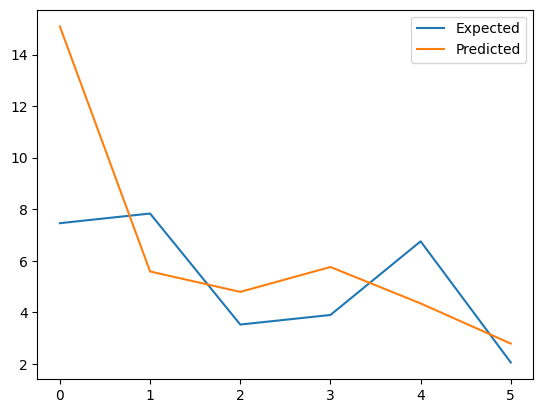

In [ ]:
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % overall_direction_accuracy)
# plot expected vs preducted
pyplot.plot(test[:, -1], label='Expected')
pyplot.plot(predictions, label='Predicted')
pyplot.legend()
pyplot.show()

Here the ME is less but RMSE is higher. And Direction Accuracy is lower.

### Rolling window forecast for XGBoost

In [ ]:

def rolling(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
 # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = model.predict(asarray([testX]))
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)

    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy

# Random Forest

Tree based models can only predict within the range of training data. This implies that we cannot just fit a Decision Tree or Random Forest to model auto-regressive dependencies.

### Walk-forward validation

In [ ]:
# walk-forward validation for univariate data
def rf_walk_forward_validation(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = random_forest_forecast(history, testX)
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = RandomForestRegressor(n_estimators=1000)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict([testX])
 return yhat[0]

In [ ]:
TS1_A1A2["wPreis"].values
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)


In [ ]:
TS1_A1A2["wPreis"].values


array([-37.51931788, -28.69009585, -29.68807862, -25.6304334 ,
       -29.07379398, -24.93642602, -35.26209517, -28.06563229,
       -27.35874871, -28.21685813, -29.18520815, -32.36064526,
       -20.27214677, -18.80845203, -35.43666563, -23.58340467,
       -23.06625847, -22.99784234, -31.41962306, -25.46027349,
       -23.68194297, -21.47771259, -27.02904785, -24.82276444,
       -23.25520954, -25.32197924, -22.30413021, -23.38024324,
       -25.17015002, -20.85821571, -23.60348981, -24.86044273,
       -23.64540855, -25.72826243, -20.17778383, -26.36851112,
       -21.90534062, -23.64226891, -25.04513087, -24.65590187,
       -21.77319638, -24.9461431 , -23.90837982, -25.23754357,
       -19.73324755, -24.54094226, -24.73818078, -22.97021231,
       -19.21154856, -16.66741517, -26.54786465, -22.45099313,
       -22.93310518, -23.38212367, -23.28028169, -26.65816299,
       -22.07703349, -17.78619097, -18.98931101,  -7.41127285,
        -6.21131882,  -1.98035287,   1.61215148,   0.48

In [ ]:
X

array([[-37.51931788],
       [-28.69009585],
       [-29.68807862],
       [-25.6304334 ],
       [-29.07379398],
       [-24.93642602],
       [-35.26209517],
       [-28.06563229],
       [-27.35874871],
       [-28.21685813],
       [-29.18520815],
       [-32.36064526],
       [-20.27214677],
       [-18.80845203],
       [-35.43666563],
       [-23.58340467],
       [-23.06625847],
       [-22.99784234],
       [-31.41962306],
       [-25.46027349],
       [-23.68194297],
       [-21.47771259],
       [-27.02904785],
       [-24.82276444],
       [-23.25520954],
       [-25.32197924],
       [-22.30413021],
       [-23.38024324],
       [-25.17015002],
       [-20.85821571],
       [-23.60348981],
       [-24.86044273],
       [-23.64540855],
       [-25.72826243],
       [-20.17778383],
       [-26.36851112],
       [-21.90534062],
       [-23.64226891],
       [-25.04513087],
       [-24.65590187],
       [-21.77319638],
       [-24.9461431 ],
       [-23.90837982],
       [-25

In [ ]:
rf_data = series_to_supervised(X, n_in=4)

>expected=7.5, predicted=15.5
>expected=7.8, predicted=8.7
>expected=3.5, predicted=10.3
>expected=3.9, predicted=7.6
>expected=6.8, predicted=6.4
>expected=2.1, predicted=6.8
MAE: 4.064
ME: 3.952
RMSE: 4.937
Direction Accuracy: 0.000


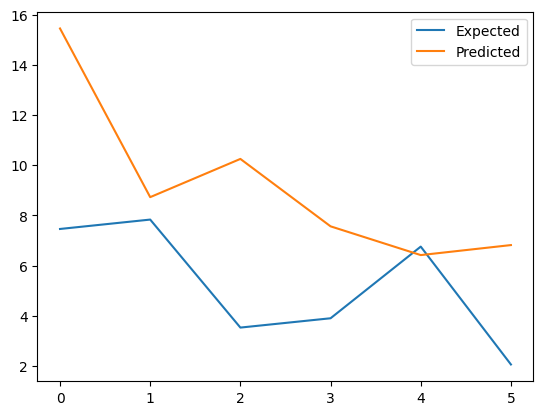

In [ ]:
# evaluate
mae, me, rmse, y, yhat, direction_accuracy = rf_walk_forward_validation(data, 6)
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

### Static forecast for Random Forest

In [147]:
# fit an random forest model and make a one step prediction
# def random_forest_static_forecast(train, testX):
 # transform list into array
train = asarray(train)
 # split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
model_rf_static = RandomForestRegressor(n_estimators=1000)
model_rf_static.fit(trainX, trainy)
 # make a one-step prediction

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [148]:
# 
def rf_staticforecast(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = model_rf_static.predict([testX])
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

In [151]:
rf_static_data = series_to_supervised(X, n_in=4)

IndexError: tuple index out of range

>expected=7.5, predicted=15.4
>expected=7.8, predicted=8.5
>expected=3.5, predicted=11.0
>expected=3.9, predicted=6.7
>expected=6.8, predicted=6.9
>expected=2.1, predicted=5.3
ME: 3.732
RMSE: 4.807
Direction Accuracy: 0.400


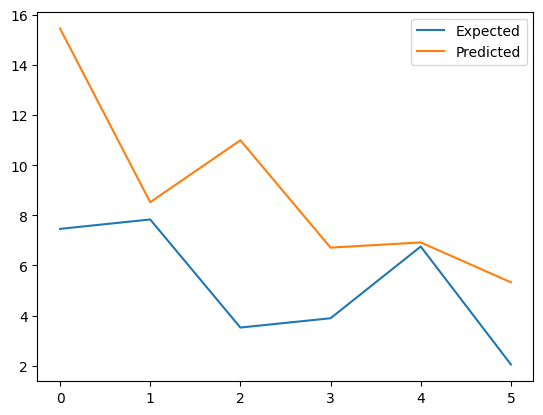

In [ ]:
# evaluate
mae, me, rmse, y, yhat, direction_accuracy = rf_staticforecast(rf_static_data, 6)
#print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()